**Assignment-3**

CUDA C++ Programming, Thrust Parallel Programming & RAPIDS

Name: Arman Garg

Roll_no: 102356002

Grp:- P1B

**Q1**

Write a CUDA C/C++ program to perform element-wise addi;on of two
vectors.

C[i]=A[i]+B[i]

Given:
Vector size: N = 1024

In [35]:
%%writefile q1.cu
#include <stdio.h>

__global__ void vecAdd(int *A, int *B, int *C) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if(i < 1024) {
        C[i] = A[i] + B[i];
        if(i < 5)
            printf("GPU thread %d computed %d\n", i, C[i]);
    }
}

int main() {
    int A[1024], B[1024], C[1024];
    int *dA, *dB, *dC;

    for(int i=0;i<1024;i++) {
        A[i] = i;
        B[i] = i;
    }

    printf("Step 1: Host arrays initialized\n");

    cudaMalloc(&dA,1024*sizeof(int));
    cudaMalloc(&dB,1024*sizeof(int));
    cudaMalloc(&dC,1024*sizeof(int));

    printf("Step 2: Device memory allocated\n");

    cudaMemcpy(dA,A,1024*sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(dB,B,1024*sizeof(int),cudaMemcpyHostToDevice);

    printf("Step 3: Data copied from Host to Device\n");

    vecAdd<<<4,256>>>(dA,dB,dC);
    cudaDeviceSynchronize();

    printf("Step 4: GPU kernel executed\n");

    cudaMemcpy(C,dC,1024*sizeof(int),cudaMemcpyDeviceToHost);

    printf("Step 5: Data copied from Device to Host\n");

    printf("Final Output (first 10 elements):\n");
    for(int i=0;i<10;i++)
        printf("%d ", C[i]);

    printf("\n");

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);

    return 0;
}

Overwriting q1.cu


In [36]:
!nvcc -arch=sm_75 q1.cu -o q1
!./q1

Step 1: Host arrays initialized
Step 2: Device memory allocated
Step 3: Data copied from Host to Device
GPU thread 0 computed 0
GPU thread 1 computed 2
GPU thread 2 computed 4
GPU thread 3 computed 6
GPU thread 4 computed 8
Step 4: GPU kernel executed
Step 5: Data copied from Device to Host
Final Output (first 10 elements):
0 2 4 6 8 10 12 14 16 18 


**Q2**

Perform the same vector addi;on as in Q1 using Thrust library only.

In [37]:
%%writefile q2.cu
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/host_vector.h>
#include <iostream>

int main() {
    std::cout << "Step 1: Creating device vectors\n";

    thrust::device_vector<int> A(1024, 1);
    thrust::device_vector<int> B(1024, 2);
    thrust::device_vector<int> C(1024);

    std::cout << "Step 2: Performing vector addition on GPU using Thrust\n";

    thrust::transform(A.begin(), A.end(), B.begin(), C.begin(), thrust::plus<int>());

    std::cout << "Step 3: Copying result from GPU to CPU\n";

    thrust::host_vector<int> H = C;

    std::cout << "Final Output (first 10 elements):\n";
    for(int i=0;i<10;i++)
        std::cout << H[i] << " ";

    std::cout << std::endl;
    return 0;
}

Overwriting q2.cu


In [38]:
!nvcc -arch=sm_75 q2.cu -o q2
!./q2

Step 1: Creating device vectors
Step 2: Performing vector addition on GPU using Thrust
Step 3: Copying result from GPU to CPU
Final Output (first 10 elements):
3 3 3 3 3 3 3 3 3 3 


**Q3**

Compute the dot product of two vectors of size, N =1024: Result=∑A[i]×B[i]
using Thrust and compare its performance with that on CPU.

In [39]:
%%writefile q3.cu
#include <thrust/device_vector.h>
#include <thrust/inner_product.h>
#include <iostream>

int main() {
    std::cout << "Step 1: Initializing vectors on GPU\n";

    thrust::device_vector<int> A(1024, 1);
    thrust::device_vector<int> B(1024, 2);

    std::cout << "Step 2: Computing dot product on GPU\n";

    int result = thrust::inner_product(A.begin(), A.end(), B.begin(), 0);

    std::cout << "Final Output (Dot Product): " << result << std::endl;

    return 0;
}

Overwriting q3.cu


In [40]:
!nvcc -arch=sm_75 q3.cu -o q3
!./q3

Step 1: Initializing vectors on GPU
Step 2: Computing dot product on GPU
Final Output (Dot Product): 2048


**Q4**

Write a CUDA kernel for matrix mul;plica;on: C=A×B where Matrix size is 16
X 16. Explain why matrix mul;plica;on needs more computa;on than
addi;on (as in Q1).

In [41]:
%%writefile q4.cu

#include <stdio.h>

__global__ void matMul(int *A, int *B, int *C) {
    int row = threadIdx.y;
    int col = threadIdx.x;
    int sum = 0;

    for(int k=0;k<16;k++)
        sum += A[row*16+k] * B[k*16+col];

    C[row*16+col] = sum;

    if(row==0 && col<5)
        printf("GPU computed C[0][%d] = %d\n", col, sum);
}

int main() {
    int hA[256], hB[256];
    int *A,*B,*C;

    for(int i=0;i<256;i++) {
        hA[i] = 1;
        hB[i] = 1;
    }

    cudaMalloc(&A,256*sizeof(int));
    cudaMalloc(&B,256*sizeof(int));
    cudaMalloc(&C,256*sizeof(int));

    printf("Step 1: Device memory allocated\n");

    cudaMemcpy(A,hA,256*sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(B,hB,256*sizeof(int),cudaMemcpyHostToDevice);

    dim3 threads(16,16);
    matMul<<<1,threads>>>(A,B,C);
    cudaDeviceSynchronize();

    printf("Step 2: Matrix multiplication completed on GPU\n");

    cudaFree(A);
    cudaFree(B);
    cudaFree(C);

    return 0;
}

Overwriting q4.cu


In [42]:
!nvcc -arch=sm_75 q4.cu -o q4
!./q4

Step 1: Device memory allocated
GPU computed C[0][0] = 16
GPU computed C[0][1] = 16
GPU computed C[0][2] = 16
GPU computed C[0][3] = 16
GPU computed C[0][4] = 16
Step 2: Matrix multiplication completed on GPU


**Q5**

For vector addition of size 5,000,000, implement and compare:

• CPU sequential C/C++ program

• CUDA kernel implementation

• Thrust implementation

• RAPIDS implementation

Measure execution time and compare complexity for each approach and
present results in a table. Plot comparison graph.

In [43]:
%%writefile q5-1.cu
#include <stdio.h>
#include <time.h>

int main() {
    int N = 5000000;
    int *A = new int[N];
    int *B = new int[N];
    int *C = new int[N];

    for(int i=0;i<N;i++) {
        A[i] = i;
        B[i] = i;
    }

    clock_t start = clock();

    for(int i=0;i<N;i++)
        C[i] = A[i] + B[i];

    clock_t end = clock();

    double time_ms = ((double)(end - start) / CLOCKS_PER_SEC) * 1000;
    printf("CPU Time: %f ms\n", time_ms);

    delete[] A;
    delete[] B;
    delete[] C;
    return 0;
}

Overwriting q5-1.cu


In [44]:
%%writefile q5-2.cu

#include <stdio.h>

__global__ void vecAdd(int *A, int *B, int *C, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if(i < N)
        C[i] = A[i] + B[i];
}

int main() {
    int N = 5000000;
    int *A, *B, *C;
    int *dA, *dB, *dC;

    A = (int*)malloc(N*sizeof(int));
    B = (int*)malloc(N*sizeof(int));
    C = (int*)malloc(N*sizeof(int));

    for(int i=0;i<N;i++) {
        A[i] = i;
        B[i] = i;
    }

    cudaMalloc(&dA, N*sizeof(int));
    cudaMalloc(&dB, N*sizeof(int));
    cudaMalloc(&dC, N*sizeof(int));

    cudaMemcpy(dA,A,N*sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(dB,B,N*sizeof(int),cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    vecAdd<<<(N+255)/256,256>>>(dA,dB,dC,N);
    cudaDeviceSynchronize();

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time_ms;
    cudaEventElapsedTime(&time_ms, start, stop);

    printf("CUDA Time: %f ms\n", time_ms);

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);
    free(A);
    free(B);
    free(C);
    return 0;
}

Writing q5-2.cu


In [45]:
%%writefile q5-3.cu

#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/sequence.h>
#include <stdio.h>

int main() {
    int N = 5000000;

    thrust::device_vector<int> A(N);
    thrust::device_vector<int> B(N);
    thrust::device_vector<int> C(N);

    thrust::sequence(A.begin(), A.end());
    thrust::sequence(B.begin(), B.end());

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    thrust::transform(A.begin(), A.end(), B.begin(), C.begin(), thrust::plus<int>());
    cudaDeviceSynchronize();

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time_ms;
    cudaEventElapsedTime(&time_ms, start, stop);

    printf("Thrust Time: %f ms\n", time_ms);

    return 0;
}

Writing q5-3.cu


In [64]:
%%writefile q5_4.py

import cudf
import cupy as cp
import time

N = 5000000

A = cp.arange(N)
B = cp.arange(N)

start = time.time()
C = A + B
cp.cuda.Stream.null.synchronize()
end = time.time()

print("RAPIDS Time:", (end - start) * 1000, "ms")

Overwriting q5_4.py


In [66]:
!nvcc -arch=sm_75 q5-1.cu -o q5-1
!nvcc -arch=sm_75 q5-2.cu -o q5-2
!nvcc -arch=sm_75 q5-3.cu -o q5-3
!./q5-1
!./q5-2
!./q5-3
!python3 q5_4.py

CPU Time: 25.668000 ms
CUDA Time: 0.320384 ms
Thrust Time: 0.259488 ms
RAPIDS Time: 107.6498031616211 ms


Execution Time Comparison Table (on GPU):
           Method  Execution Time (ms) Time Complexity
0  CPU Sequential            25.668000            O(N)
1     CUDA Kernel             0.320384  O(N / threads)
2          Thrust             0.259488            O(N)
3          RAPIDS           107.649803       Optimized


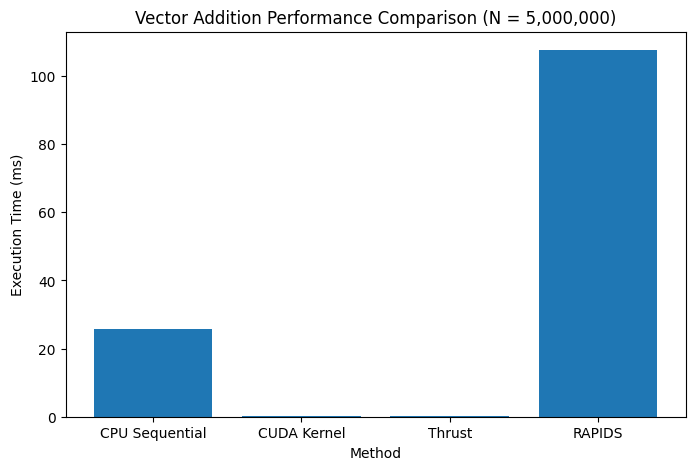

In [68]:
import cudf
import cupy as cp
import matplotlib.pyplot as plt

methods = ["CPU Sequential", "CUDA Kernel", "Thrust", "RAPIDS"]
times = cp.array([25.668000, 0.320384, 0.259488, 107.6498031616211])

df = cudf.DataFrame({
    "Method": methods,
    "Execution Time (ms)": times,
    "Time Complexity": ["O(N)", "O(N / threads)", "O(N)", "Optimized"]
})

print("Execution Time Comparison Table (on GPU):")
print(df)

plt.figure(figsize=(8,5))
plt.bar(methods, times.get())
plt.xlabel("Method")
plt.ylabel("Execution Time (ms)")
plt.title("Vector Addition Performance Comparison (N = 5,000,000)")
plt.show()

**Q6**

Write a CUDA C++ program using the Thrust library to compute the sum of
all elements in a vector stored on the GPU. The vector is of size 10 and it
should be initialized with values 1,…..10.

In [49]:
%%writefile q6.cu
#include <thrust/device_vector.h>
#include <thrust/reduce.h>
#include <thrust/sequence.h>
#include <iostream>

int main() {
    std::cout << "Step 1: Creating vector on GPU\n";

    thrust::device_vector<int> v(10);
    thrust::sequence(v.begin(), v.end(), 1);

    std::cout << "Step 2: Reducing vector on GPU\n";

    int sum = thrust::reduce(v.begin(), v.end(), 0);

    std::cout << "Final Output (Sum): " << sum << std::endl;

    return 0;
}

Overwriting q6.cu


In [50]:
!nvcc -arch=sm_75 q6.cu -o q6
!./q6

Step 1: Creating vector on GPU
Step 2: Reducing vector on GPU
Final Output (Sum): 55


**Q7**

Write a CUDA C++ program using Thrust to sort (ascending) a vector of
integers on the GPU. Consider vector size 8 with following values: 7, 2, 9, 1, 5, 3, 8, 4. Print the vector before and afer sorting.

In [51]:
%%writefile q7.cu
#include <thrust/device_vector.h>
#include <thrust/sort.h>
#include <thrust/host_vector.h>
#include <iostream>

int main() {
    thrust::device_vector<int> v = {7,2,9,1,5,3,8,4};

    thrust::host_vector<int> h1 = v;

    std::cout << "Before Sorting:\n";
    for(int i=0;i<8;i++)
        std::cout << h1[i] << " ";
    std::cout << std::endl;

    thrust::sort(v.begin(), v.end());

    thrust::host_vector<int> h2 = v;

    std::cout << "After Sorting:\n";
    for(int i=0;i<8;i++)
        std::cout << h2[i] << " ";
    std::cout << std::endl;

    return 0;
}

Overwriting q7.cu


In [52]:
!nvcc -arch=sm_75 q7.cu -o q7
!./q7

Before Sorting:
7 2 9 1 5 3 8 4 
After Sorting:
1 2 3 4 5 7 8 9 
